In [4]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


def parse_milvus_results(file_path):
    data = []
    with open(file_path, "r") as f:
        content = f.readlines()
        lines = content[1:]
        for l in lines:
            nprobe, _ , latency=l.split("|")
            nprobe = nprobe.strip().split("=")[-1].strip()
            latency = latency.split("=")[1].split()[0]
            data.append(
                {
                    "nprobe": int(nprobe),
                    "latency_ms": float(latency),
                }
            )
    return {
        "file": file_path,
        "data": data,
    }




In [5]:

settings = ["never", "madvise", "always"]                                                                                  
def get_data(results_dir: str):
    data = []
    for setting in settings:
        milvus_file = os.path.join(results_dir, f"hnsw_results_{setting}.txt")
        perf_file = os.path.join(results_dir, f"perf_results_{setting}.txt")
        if not (os.path.exists(milvus_file) and os.path.exists(perf_file)):
            print(
                f"Warning: Result files for setting '{setting}' not found. Skipping."
            )
            continue
        result = {"setting": setting}
        result.update(parse_milvus_results(milvus_file))
        data.append(result)
    if not data:
        print(
            "Error: No data was parsed. Please check the 'test_results' directory."
        )
    return data
                                                                                      
glibc_data = get_data("test_results_glibc/milvus")


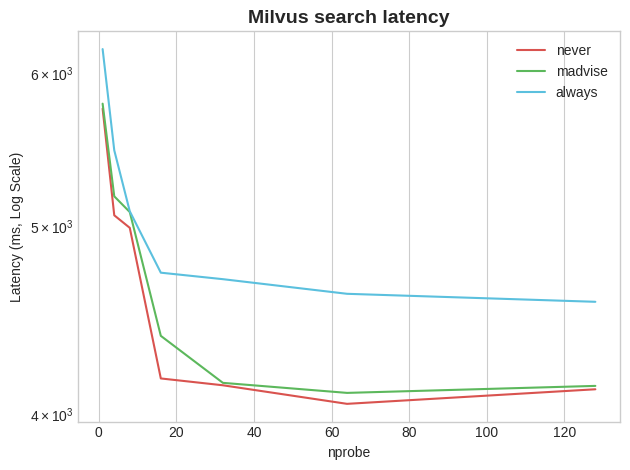

In [10]:
plt.style.use("seaborn-v0_8-whitegrid")

colors = ["#d9534f", "#5cb85c", "#5bc0de"]

plot_data = []
for data, color, setting in zip(glibc_data, colors, settings):
    p50_data = []
    p99_9_data = []
    nprobe = []
    for pt in data["data"]:
        p50_data.append(pt["latency_ms"])
        nprobe.append(pt["nprobe"])
    plot_data.append({
        "label": setting,
        "latency": p50_data,
        "nprobe": nprobe,
        "color": color,
    })

fig3, ax3 = plt.subplots()
for pd in plot_data:
    if "tcmalloc" in pd["label"]:
        continue
    ax3.plot(pd["nprobe"], pd["latency"], color=pd["color"], label=pd["label"])
ax3.set_title("Milvus search latency", fontsize=14, fontweight="bold")
ax3.set_ylabel("Latency (ms, Log Scale)")
ax3.set_xlabel("nprobe")
ax3.set_yscale("log")  # Use log scale due to huge difference in misses for some
ax3.legend()
ax3.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"{int(y):,}"))
fig3.tight_layout()
plt.savefig("test_results_glibc/milvus/results.png")

plt.show()